In [1]:
import pandas as pd
from os import path

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from scipy.signal import resample

#adding local modules
import sys
module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import load_biodarw #todo move to python package
from preprocess.biodarw_feature_extraction import extract_residues, extract_features_of
from properties import properties

coefficients=17
mini_batch_size=8

%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#Load meta data
metadf=pd.read_csv(path.join("/data/elekin/doc","metadata-202106-v1.csv"),index_col=0)
metadf.head(16)

,abs_path,relative_path,temblor,Sexo,TRS,age,level
name,,,,,,,
C01_1,/data/elekin/data/origin/ethw/Controles30jun14...,C01/session00002/u00003s00002_hw000011.svc,no,F,0,27,0
C01_2,/data/elekin/data/origin/ethw/Controles30jun14...,C01/session00002/u00003s00002_hw000012.svc,no,F,0,27,0
C02_1,/data/elekin/data/origin/ethw/Controles30jun14...,C02/session00001/u00004s00001_hw000011.svc,no,F,0,29,0
C02_2,/data/elekin/data/origin/ethw/Controles30jun14...,C02/session00001/u00004s00001_hw000012.svc,no,F,0,29,0
C03_1,/data/elekin/data/origin/ethw/Controles30jun14...,C03/session00001/u00005s00001_hw000011.svc,no,F,0,32,0
C03_2,/data/elekin/data/origin/ethw/Controles30jun14...,C03/session00001/u00005s00001_hw000012.svc,no,F,0,32,0
C04_1,/data/elekin/data/origin/ethw/Controles30jun14...,C04/session00001/u00006s00001_hw000011.svc,no,M,0,32,0
C04_2,/data/elekin/data/origin/ethw/Controles30jun14...,C04/session00001/u00006s00001_hw000012.svc,no,M,0,32,0
C05_1,/data/elekin/data/origin/ethw/Controles30jun14...,C05/session00001/u00007s00001_hw000011.svc,no,M,0,22,0


In [3]:
#Load data
dataset=load_biodarw(metadf.index, metadf['abs_path'])

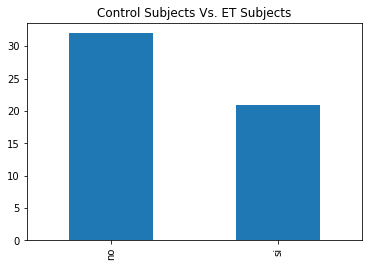

In [4]:
#Loading labels based on clinic, residues and features from residues.
labels = metadf['temblor']
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects')

In [5]:
rd = dataset.groupby('subject_id').apply(extract_residues, c=coefficients).apply(resample, num=4096)
rd_rd = pd.DataFrame(rd.tolist(), index=rd.index)
rd_rd.head(16)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,7.349452e-15,-13.291940,1.024601,10.161138,3.315941,-3.097414,1.440666,7.129718,4.707049,0.572884,...,97.448900,95.955542,101.818591,104.332167,95.874072,89.940103,101.853141,116.800260,101.116099,49.724857
C01_2,6.756754e-14,-31.209053,-0.017404,17.752622,1.237945,-9.987982,2.213369,11.402657,2.611116,-4.204175,...,222.096143,213.065104,221.689744,232.912255,220.952794,204.349330,222.760910,255.393283,225.934430,113.379869
C02_1,3.542767e-14,-60.542107,-27.549071,22.667162,29.774608,-0.049968,-21.247772,-10.065639,13.253232,17.932418,...,344.367840,374.472317,380.804964,362.103375,356.832894,397.935247,458.875221,461.692858,352.041872,164.092353
C02_2,0.000000e+00,-27.968298,3.847043,19.568139,4.392351,-0.129432,17.771599,29.816480,28.274217,34.182908,...,214.985799,204.703211,209.397646,222.910419,215.988709,197.589052,209.616093,241.172176,216.979362,109.734380
C03_1,-1.448672e-13,-24.217525,0.030620,15.214947,2.708331,-8.058323,0.193426,9.060716,3.685560,-3.239162,...,110.591346,104.897082,115.563854,127.342230,121.951827,117.953167,145.015919,181.972929,167.326704,85.417298
C03_2,-3.216604e-14,-4.743053,2.357251,4.825403,1.856053,3.416943,9.272533,11.910841,11.251721,11.652002,...,36.862525,35.561624,34.204905,36.363264,37.555728,34.273989,33.939043,40.137283,39.286630,21.104560
C04_1,1.275924e-14,-19.238670,4.887121,9.269133,-5.603701,-4.442068,5.761753,2.020816,-4.567960,0.597289,...,77.518802,72.292842,64.360034,75.220587,89.323213,86.753011,95.350440,133.114825,143.943629,80.689566
C04_2,-8.748646e-14,-6.639625,7.783162,-1.958290,-0.019630,4.697744,-0.645690,3.079784,4.094312,2.093642,...,82.562342,79.182332,82.388434,82.390361,78.429148,85.139955,80.384840,77.471092,93.832116,63.282700
C05_1,0.000000e+00,-27.907347,10.881926,10.252521,-11.110835,-1.430228,9.070397,-2.783219,-4.909954,5.666420,...,107.457379,118.450235,114.096347,128.871858,158.741696,158.948752,160.007117,212.835150,236.414668,134.861681


In [6]:
rd_fe = rd_rd.apply(extract_features_of, axis='columns')
rd_fe_df = pd.DataFrame(rd_fe.tolist(), index=rd_fe.index)
rd_fe_df.columns = properties.features_names
rd_fe_df.head(10)

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mean_abs_val(L),np.var(L),root_mean_square(L),log_detector(L),wl(L),np.nanstd(L),diff_abs_std(L),higuchi(L),mfl(L),myo(L),...,mp(Pxx),tp(Pxx),meanfreq(L),medfreq(L),std_psd(Pxx),"mmnt(Pxx, order=1)","mmnt(Pxx, order=2)","mmnt(Pxx, order=3)",kurt(Pxx),skw(Pxx)
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,49.126938,579.214832,2991.884615,1.481945e+05,2699.037990,24.066882,1.295932,1.128751,7.900651,0.034912,...,1157.864302,2.372464e+06,0.482965,4.935226e-07,12984.128822,0.0,1.685876e+08,4.035712e+13,379.432492,18.436636
C01_2,103.875361,1422.441845,12207.925570,1.507897e+07,3315.663497,37.715273,2.369122,1.141845,8.106413,0.024414,...,2843.495264,5.826322e+06,0.308932,5.245028e-04,41627.379824,0.0,1.732839e+09,2.226823e+15,1135.541448,30.870836
C02_1,184.378883,1771.496590,35743.222575,2.499714e+08,4277.139156,42.089151,4.212909,1.206015,8.361040,0.001221,...,3541.264048,7.256050e+06,0.305239,5.254505e-09,48745.318957,0.0,2.376106e+09,3.085184e+15,801.691274,26.636816
C02_2,175.072411,3183.991421,33829.536776,0.000000e+00,4960.916938,56.426868,2.571402,1.074432,8.509346,0.000000,...,6364.874993,1.304163e+07,0.336631,7.044272e-04,112793.372861,0.0,1.272234e+10,4.540967e+16,1135.182799,31.644452
C03_1,126.603976,793.624772,16817.800976,8.887517e+06,3113.390389,28.171347,1.900023,1.151635,8.043468,0.000000,...,1586.474897,3.250687e+06,0.358821,1.045931e-05,29819.052333,0.0,8.891759e+08,9.695595e+14,1487.496284,36.567304
C03_2,54.155146,997.398216,3929.927246,4.900677e+05,3573.992513,31.581612,1.164280,1.043389,8.181439,0.053467,...,1993.822885,4.085343e+06,0.509054,7.229303e-04,22541.427165,0.0,5.081159e+08,2.252975e+14,504.943379,19.670349
C04_1,68.902039,1454.842390,6199.726708,2.183167e+06,3566.669263,38.142396,1.743398,1.106679,8.179387,0.050293,...,2908.264728,5.959034e+06,0.338666,1.502752e-03,52529.257365,0.0,2.759323e+09,5.031503e+15,1372.121688,34.713141
C04_2,110.962646,1121.933479,13433.638511,1.187093e+07,3987.962964,33.495275,1.619546,1.087638,8.291036,0.000000,...,2242.771855,4.595440e+06,0.389063,1.240298e-03,38161.646682,0.0,1.456311e+09,1.993012e+15,1451.781263,35.861513
C05_1,82.752114,1631.416202,8474.794876,0.000000e+00,4513.304735,40.390794,2.513840,1.122156,8.414785,0.020996,...,3261.240002,6.682281e+06,0.369130,9.573803e-04,53972.743265,0.0,2.913057e+09,4.022433e+15,735.869035,25.583817


In [7]:
#Train test split and scale timeseries between 0 and 1
from sklearn.model_selection import train_test_split

labels = (metadf["temblor"] == 'si').astype('int8')
y=labels.values
x_train, x_test, y_train, y_test = train_test_split(rd_fe_df.values, y, test_size=0.33, random_state=42)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(2).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(2).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

for feat, targ in test_dataset.take(10):
    print ('Features test: {}, Target: {}'.format(feat, targ))

for feat, targ in test_dataset.take(10):
    print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))
test_dataset

Features test: [[4.56971896e+03 1.78755421e+05 2.10579594e+07 1.23429532e+22
  4.28461333e+04 4.22794774e+02 5.95364012e+01 1.49457955e+00
  1.06653707e+01 0.00000000e+00 1.87175689e+07 8.62534018e+10
  2.01600000e+03 5.64000000e+02 0.00000000e+00 7.60116272e+03
  6.18611323e+07 3.57336361e+05 7.32182203e+08 4.28514841e-01
  1.26478210e+00 2.76718120e+06 0.00000000e+00 7.65729178e+12
  2.72019138e+20 2.01304607e+02 1.28376835e+01]
 [2.66646173e+03 1.17210047e+04 7.12111394e+06 1.06592488e+16
  2.27567492e+04 1.08263589e+02 4.00975210e+01 1.60864128e+00
  1.00326170e+01 0.00000000e+00 1.09218273e+07 2.91680827e+10
  2.20400000e+03 8.96000000e+02 0.00000000e+00 2.90857983e+03
  2.26836415e+06 2.34305686e+04 4.80092351e+07 3.54483874e-01
  1.20066748e-03 9.21558902e+04 0.00000000e+00 8.49270810e+09
  1.25513671e+16 3.15768800e+02 1.60369485e+01]
 [3.40055857e+03 5.74600663e+03 1.15695446e+07 1.91824189e+15
  2.11636878e+04 7.58024184e+01 5.50216406e+01 1.68694104e+00
  9.96004215e+00 0.00

<CacheDataset element_spec=(TensorSpec(shape=(None, 27), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>